## <b>ENPH 213 Final Project - Plinko!</b>
By Sam Alexander (20158924) and Nathan Ingram (20188635)

We hope you enjoy!

In [1]:
###TAKES A BIT OF TIME TO DO 75 RUNS (4TIMES)... PLEASE BE PATIENT AS IT OUTPUTS!!!

import numpy as np
from matplotlib import pyplot as plt

g = 9.8

#Generate the pegs
def Peggle():
    peggles = np.zeros((105, 2))
    
    Space = 0.1*np.cos(np.pi/6)
    
    k = 0
    for j in range(5):
        for i in range(11):
            peggles[k] = [i*0.1, (2*j + 1)*Space]
            k += 1
        for i in range(10):
            peggles[k] = [i*0.1 + 0.05, 2*j*Space]
            k += 1
    
    return peggles

#Drag in X
def DragFunctionX(cDrag, vx):
    return -cDrag*(vx**2)*np.sign(vx)

#Drag in Y
def DragFunctionY(cDrag, vy):
    return -g-cDrag*(vy**2)*np.sign(vy)

#Returns a random number that fits the required variance
def RandomReturn():
    return (np.random.rand()-0.5)*0.004

#Simulation function to drop the plinko (the peg category just allows for the passing of the right pegs array)
#--> PrintCheck allows for one "sample" to be printed if passed by the Histo() func below
def Plinko(xStart, cDrag, tMax, peg, PrintCheck):
    #Radii of the ball and pegs
    rBall = 0.025
    rPeg = 0.005
    
    #Initiate important arrays and constants/lengths
    tstep = 1e-3
    N = int(tMax/tstep)
    
    #Create our desired arrays (4 return vals)
    x = np.zeros(N)
    y = np.zeros(N)
    vx = np.zeros(N)
    vy = np.zeros(N)
    
    #Initialize the first point
    x[0] = xStart + RandomReturn()
    y[0] = 0.9 + RandomReturn()
    
    #Initialize the velocities
    vx[0] = RandomReturn()
    vy[0] = RandomReturn()
    
    #Our total distance travelled
    distancetotal = 0
    
    #Fake value that prevents a runtime error if the sim is killed before it finishes
    finalBin = 0
    
    finishTime = 0
    #Loop thru from 1->N to find each point
    for i in range(1, N):
        #Next velocities
        vx[i] = vx[i-1] + DragFunctionX(cDrag,vx[i-1])*tstep
        vy[i] = vy[i-1] + DragFunctionY(cDrag,vy[i-1])*tstep
        
        #Next positions
        x[i] = x[i-1] + vx[i]*tstep
        y[i] = y[i-1] + vy[i]*tstep
        
        #Calculate the step distance
        deltaY = (y[i]-y[i-1])
        deltaX = (x[i]-x[i-1])
        
        #Here, checking to see if the ball travels from one side to the other (shouldnt be counted in total distance)
        if (deltaX > 0.5):
            deltaX -= 1
        
        delta = np.sqrt(deltaX**2 + deltaY**2)
        
        distancetotal += delta
        
        #Time for the contingency cases:
        #1: There is a collision!
        #This array detects if there is a minimum collision anywhere on the field
        distanceArray = ((peg - [x[i], y[i]])*(peg - [x[i], y[i]])).sum(1)
        
        #Check if the smallest distance is a collision
        if (distanceArray.min() < (rBall + rPeg)*(rBall + rPeg)):
            #Find the peg
            argMin = np.argmin(distanceArray)
            
            #Solve the matrix (using the normal vector to limit the amount of sinusoidal functions needed)
            n = -(peg[argMin] - [x[i], y[i]])
            vx[i], vy[i] = -2*np.dot(n/np.linalg.norm(n), [vx[i], vy[i]])*n/np.linalg.norm(n) + [vx[i], vy[i]]
            
            #Introduce uncertainty to the rebound values
            vx[i], vy[i] = (1 - np.random.rand(2)*0.05)*[vx[i], vy[i]]

            #replace the ball outside the peg's radius
            x[i] = x[i-1]
            y[i] = y[i-1]
            
        #2: The ball goes off the edge
        x[i] %= 1
        
        #3: The ball reaches the bottom --> END!
        if y[i] < 0:
            #find the time it took
            timeEnd = i
            FinishTime = i*tstep
            
            #Find the bin it landed in!
            xFinal = int((x[i])*100 + 10)
            Finalbin = int((xFinal-5)/10)
            if Finalbin == 10:
                Finalbin = 0
            
            #End it!
            y[i:] = y[i]
            x[i:] = x[i]
            break
            
        else:
            timeEnd = i
                
    #FFT Time!
    #20 is the index location of 1 in the frequency array... calculated from the base interval being 0.05Hz
    freqMag1 = abs(np.fft.fft(vy)[0:timeEnd])*100
    freqs1 = np.linspace(0, freqMag1.size/tMax, freqMag1.size)
    
    freqMagCheck = freqMag1[20:]
    
    fMax = freqs1[np.argmax(freqMagCheck)+20]
    
    #Integration time using np.diff function
    freqInt = freqs1.copy()
    freqInt[freqInt > 150] = 0
    dfreq = np.diff(freqInt)
    
    intVal = (freqMag1[1:]*dfreq).sum()
    
    if (PrintCheck == 1):
        #Print the final time and distance + bin!
        print("The ball took %.2f seconds to reach the bottom!" % FinishTime)
        print("In this time, the ball travelled %.2f meters!" % distancetotal)
        print("The ball landed in bin %d!" % Finalbin)
        print("The maximum frequency value was %.2f Hz!" % fMax)
        print("The integral of the frequency range is %.2f Hz!" % intVal)
        
        #Plot the figures we want!
        fig, ax = plt.subplots(figsize=(12,8), dpi = 80)
        ax.scatter(pegBoard[:,0], pegBoard[:,1], s = 600, color=(0,0,0))
        ax.plot(x,y,"r.")
        plt.title("PLINKO")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

        #x and y vs.time
        t = np.linspace(0,FinishTime,timeEnd)

        plt.plot(t,x[0:timeEnd],'r.')
        plt.plot(t,y[0:timeEnd],'b.')
        plt.legend(["x", "y"])
        plt.title("X and Y as a fucntion of time")
        plt.ylabel("Position")
        plt.xlabel("time")
        plt.show()

        #vx and vy vs. time
        plt.plot(t,vx[0:timeEnd],'r')
        plt.plot(t,vy[0:timeEnd],'b')
        plt.legend(["vx", "vy"])
        plt.title("X and Y veloctiy as a function of time")
        plt.ylabel("velocity")
        plt.xlabel("time")
        plt.show()

        #amplitude of frequency as a function of frequency
        plt.plot(freqs1[20:],freqMag1[20:])
        plt.title("Freq Amplitude as a Function of Frequency")
        plt.xlabel("Freq")
        plt.ylabel("Amplitude")
        plt.show()
        
    #Return our required 5 values
    return FinishTime, distancetotal, Finalbin, fMax, intVal

#This function just runs the simulation a number of times and plots histograms of the returned data
def Histo(xStart, cDrag, tMax, pegPass, numRuns):
    #Initiate the storing arrays!
    Time = np.zeros(numRuns)
    Distance = np.zeros(numRuns)
    Bin = np.zeros(numRuns)
    MaxF = np.zeros(numRuns)
    Integral = np.zeros(numRuns)
    
    #Start the runs!
    for i in range(numRuns):
        if i == numRuns//2:
            Time[i], Distance[i], Bin[i], MaxF[i], Integral[i] = Plinko(xStart, cDrag, tMax, pegPass, 1)
        else:
            Time[i], Distance[i], Bin[i], MaxF[i], Integral[i] = Plinko(xStart, cDrag, tMax, pegPass, 0)
    
    #Now we plot our histograms!
    print("\n\n\n")
    print("HISTOGRAM DATA!")
    
    #Time:
    plt.hist(Time, bins = 20)
    plt.title("Histogram plot of Time")
    plt.xlabel("Bin Value")
    plt.ylabel("# of Occurences")
    plt.show()
    
    #Distance
    plt.hist(Distance, bins = 20)
    plt.title("Histogram plot of Distance")
    plt.xlabel("Bin Value")
    plt.ylabel("# of Occurences")
    plt.show()
    
    #Bin Landed in
    plt.hist(Bin, bins = 10)
    plt.title("Bin histogram plot")
    plt.xlabel("Bin Value")
    plt.ylabel("# of Occurences")
    plt.show()
    
    #Max Frequency
    plt.hist(MaxF, bins = 20)
    plt.title("Max Frequency histogram plot")
    plt.xlabel("Bin Value")
    plt.ylabel("# of Occurences")
    plt.show()
    
    #Ingegral from 1->150Hz
    plt.hist(Integral, bins = 20)
    plt.title("Frequency Integral histogram plot")
    plt.xlabel("Bin Value")
    plt.ylabel("# of Occurences")
    plt.show()
    
#Board used
pegBoard = Peggle()

<b>Drag Coeff = 0

The ball took 2.23 seconds to reach the bottom!
In this time, the ball travelled 3.71 meters!
The ball landed in bin 6!
The maximum frequency value was 3.35 Hz!
The integral of the frequency range is 887939.97 Hz!


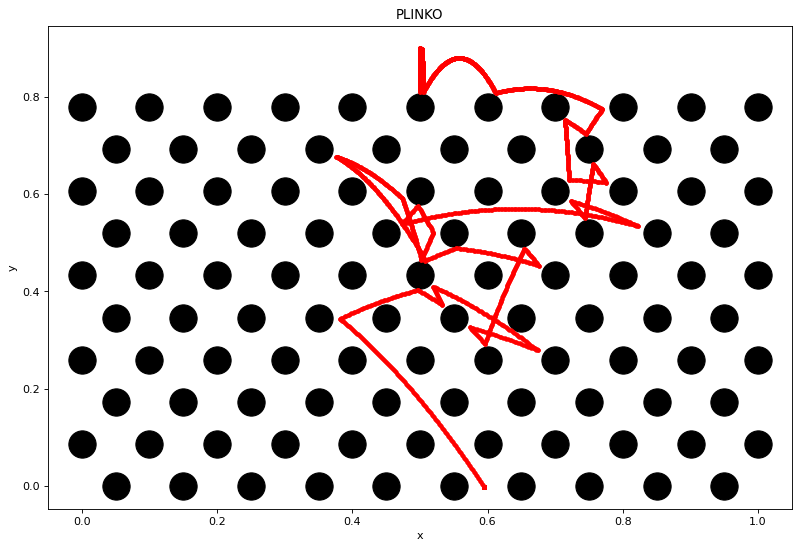

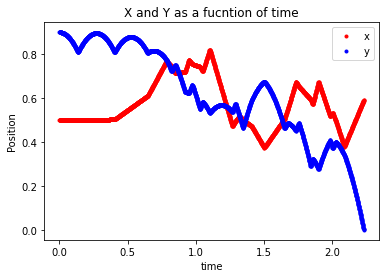

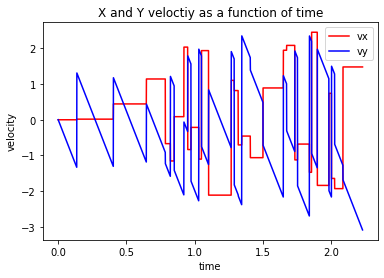

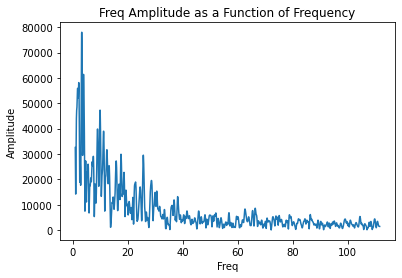





HISTOGRAM DATA!


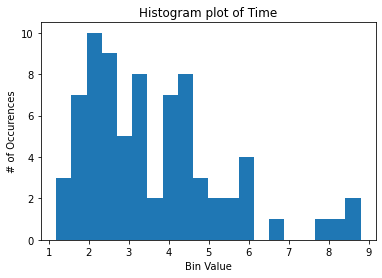

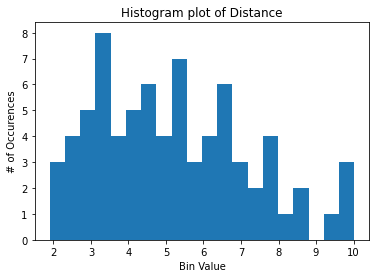

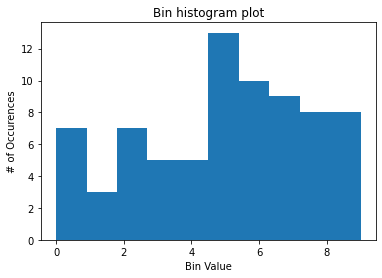

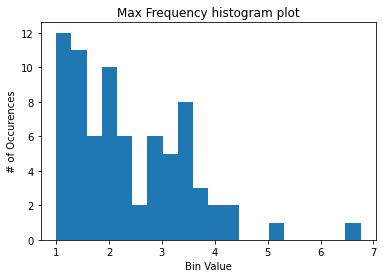

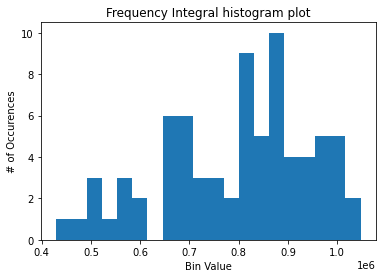

In [2]:
#Coefficient of 0
Histo(0.5,0.0,20,pegBoard, 75)

<b>Drag Coeff = 0.01</b>

The ball took 1.28 seconds to reach the bottom!
In this time, the ball travelled 2.06 meters!
The ball landed in bin 6!
The maximum frequency value was 2.55 Hz!
The integral of the frequency range is 454274.51 Hz!


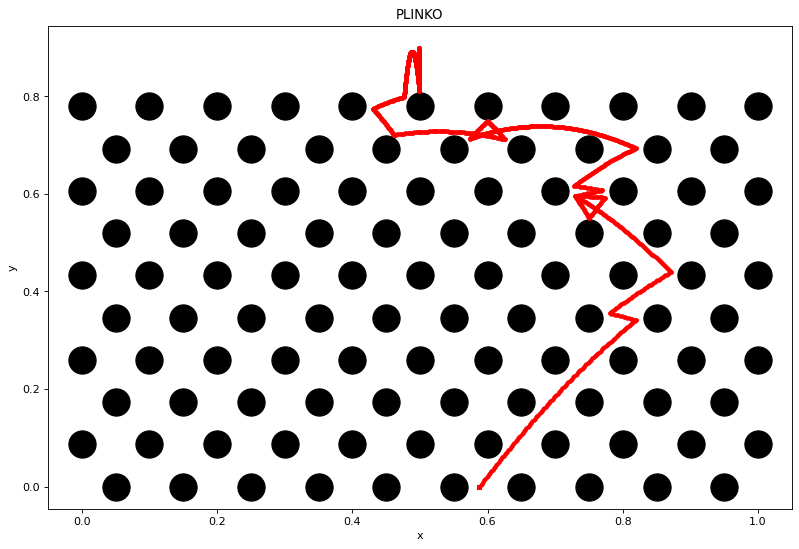

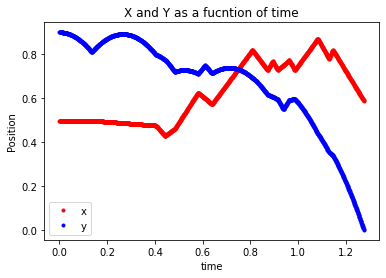

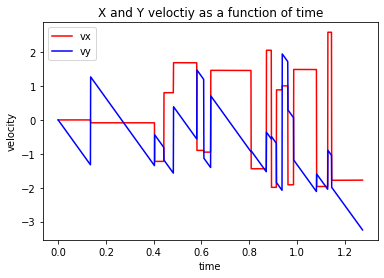

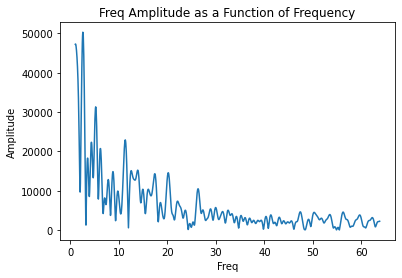





HISTOGRAM DATA!


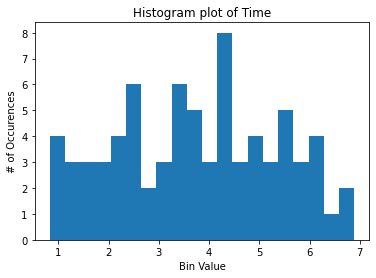

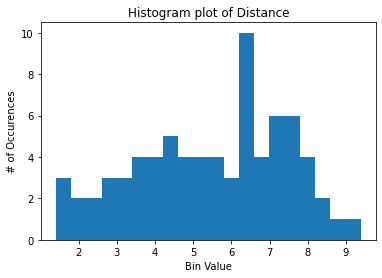

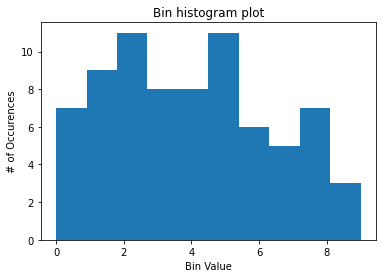

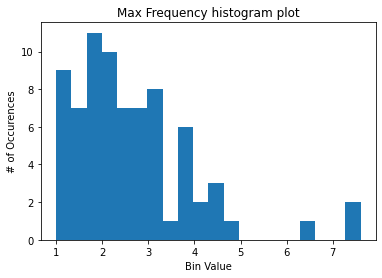

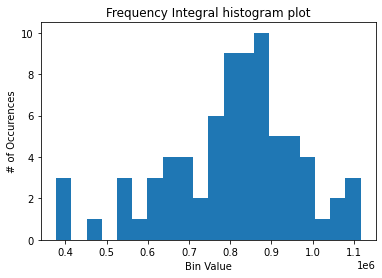

In [3]:
#Coefficient of 0.01
Histo(0.5,0.01,20,pegBoard, 75)

<b>Drag Coeff = 0.05</b>

The ball took 4.34 seconds to reach the bottom!
In this time, the ball travelled 6.22 meters!
The ball landed in bin 2!
The maximum frequency value was 2.80 Hz!
The integral of the frequency range is 863481.64 Hz!


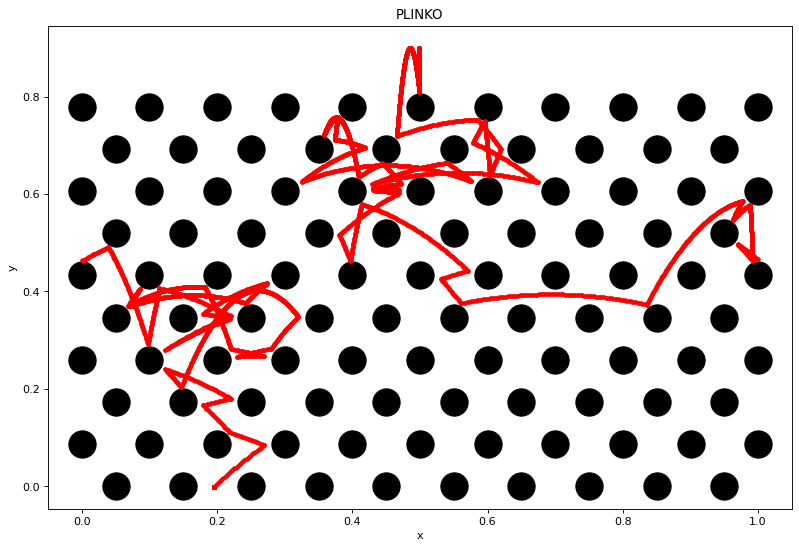

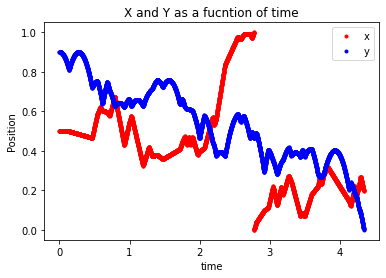

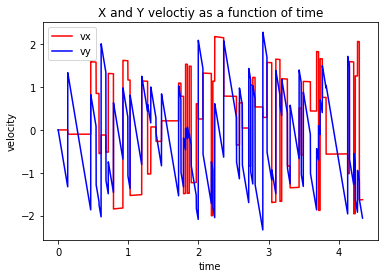

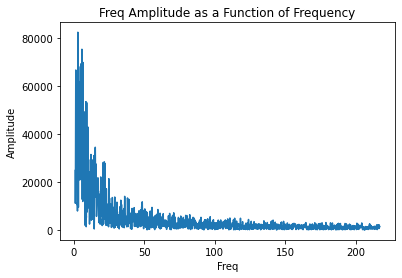





HISTOGRAM DATA!


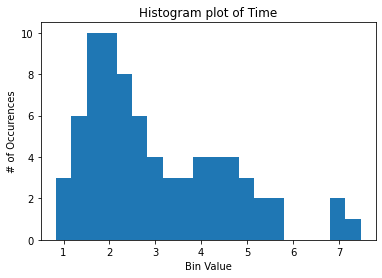

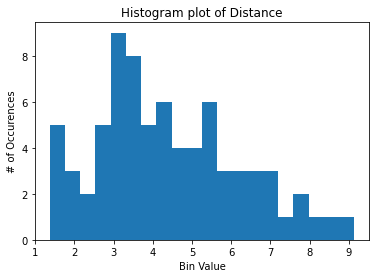

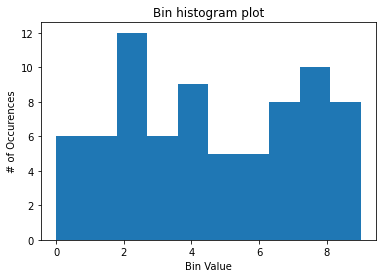

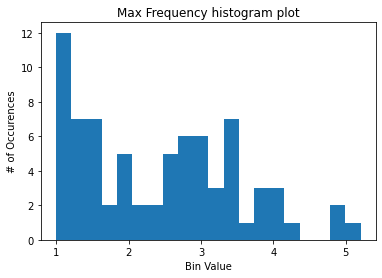

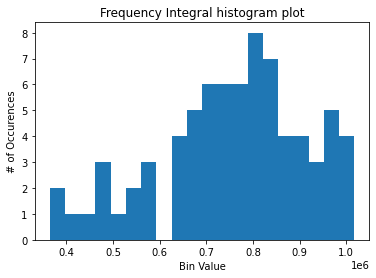

In [4]:
#Coefficient of 0.05
Histo(0.5,0.05,20,pegBoard, 75)

<b>Drag Coeff = 0.5</b>

The ball took 4.33 seconds to reach the bottom!
In this time, the ball travelled 4.94 meters!
The ball landed in bin 0!
The maximum frequency value was 6.15 Hz!
The integral of the frequency range is 744769.72 Hz!


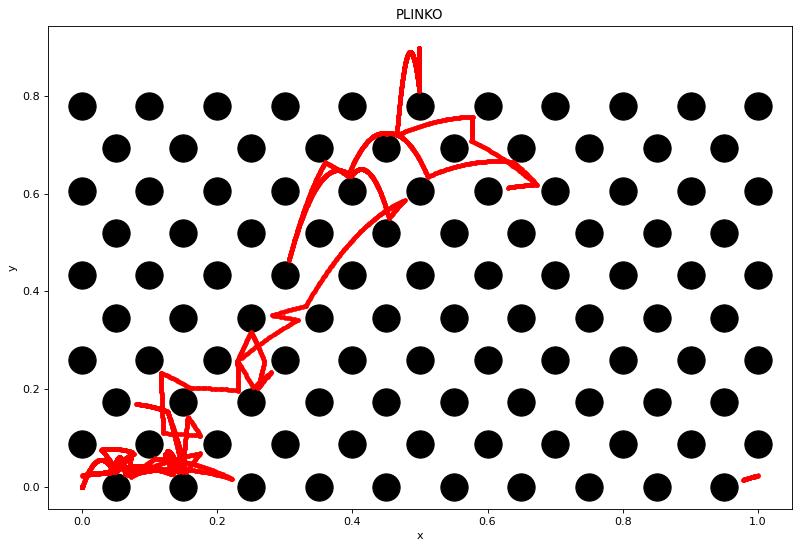

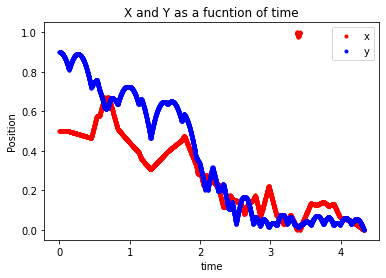

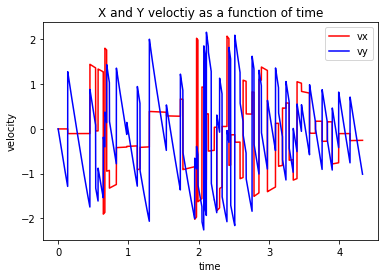

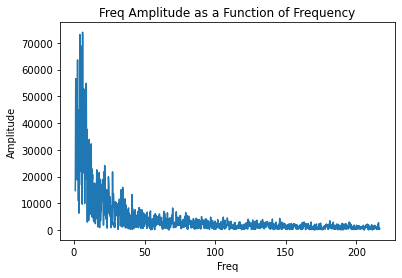





HISTOGRAM DATA!


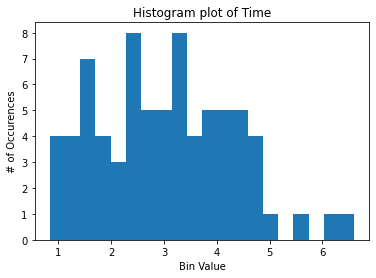

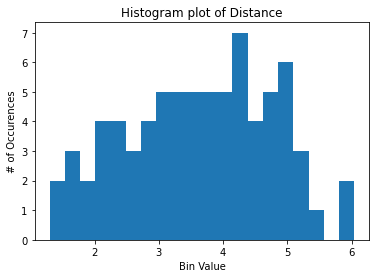

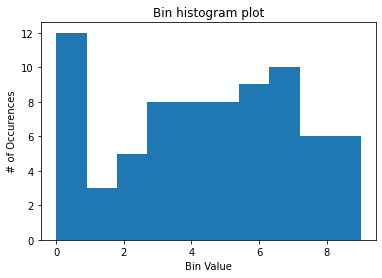

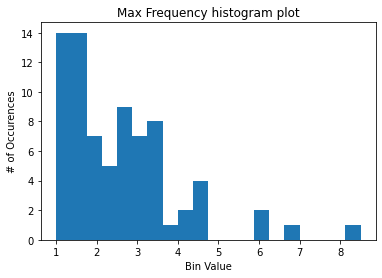

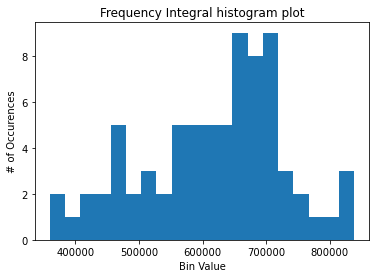

In [5]:
#Coefficient of 0.5
Histo(0.5,0.5,20,pegBoard, 75)